<a href="https://colab.research.google.com/github/reidmueller/Learn-Git/blob/master/Voting_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## branched from https://github.com/FabianWe/schulze_voting
Will accept Excel or CSV with fist column with names of projects and first row with names of rankers (voters).
The scores should refelect relative preferneces. If a ranker has no feelings about a project they do not need to rank it. The magnitude of a score or ranking has no effect.

In [1]:
import pandas as pd # to facilitate import of dataframes from Excel and CSV
import random # only needed for random vote generation function
from pprint import pprint # nicer disply of dataframes and lists
import pathlib


In [2]:
SANITY_CHECK=1 # set to 0=print nothing extra, 1=print the important stuff, 2=print everything

In [4]:
BALLOTS_DATA_PATH=r'/content/'
FILENAME='RankingBallotTestD.xlsx'

path=pathlib.Path.home().joinpath(BALLOTS_DATA_PATH,FILENAME)

if path.suffix=='.csv':
    df=pd.read_csv(path)
elif path.suffix=='.xlsx':
        df=pd.read_excel(path)
else: raise Exception('File suffix should csv or xlsx. The suffix was: {}'.format(path.suffix))

In [5]:
from collections import defaultdict


class SchulzeVote(object):
    """Class for a Schulze voting.
    It contains the weight of a voter (default 1) and the ranking. That is
    if there are n options to vote for for each option it contains the ranking
    position.
    Attributes:
        ranking (list of int): For each option the position in the ranking.
        weight (int): Weight of the voter (how many votes a single voter has).
    Example:
        Suppose that there are 4 options to vote for (A, B, C and D). The voter
        wants to rank A > B = D > C. This can be created with:
        >>> vote = SchulzeVote([0, 1, 2, 1])
    """
    def __init__(self, ranking, weight=1):
        self.ranking = ranking
        self.weight = weight


class SchulzeRes(object):
    """Class that contains all (intermediate) results for the Schulze voting.
    For details see <https://en.wikipedia.org/wiki/Schulze_method>.
    This result contains the matrices d and p as well as the computed ranking.
    A result is generally computed by the evaluate_schulze function.
    Attributes:
        d (list of list of int): The matrix d
        p (list of list of int): The matrix p
        ranked_list (list of list of int): A list describing which options
            win against the other options. The first list contains all options
            that are ranked highest, the next list all entries ranked second
            best and so on.
    """
    def __init__(self):
        self.d = None
        self.p = None
        self.candidate_wins = None


def compute_d(votes, n):
    """Compute the matrix d given the Schulze votes.
    This is the matrix of the sum of pairwise comparisons.
    Args:
        votes (list of SchulzeVote): All votes to compute the matrix from.
        n (int): The number of options in the vote. All rankings in votes must
            have length n. This is not checked, however an IndexError may be
            raised if rankings are too short.
        Returns:
            list of list of int: The matrix d.
    """
    res = [ [0 for _ in range(n)] for _ in range(n) ]
    for vote in votes:
        w = vote.weight
        ranking = vote.ranking
        for i in range(n):
            for j in range(i+1, n):
                if ranking[i] < ranking[j]:
                    res[i][j] += w
                elif ranking[j] < ranking[i]:
                    res[j][i] += w
    return res


def compute_p(d, n):
    """Compute the matrix p given the matrix d.
    This is the matrix of the strength of the strongest path.
    Args:
        d (list of list of int): The matrix d.
        n (int): Number of options in the vote.
    Returns:
        list of list of int: The matrix p.
    """
    res = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                if d[i][j] > d[j][i]:
                    res[i][j] = d[i][j]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            for k in range(n):
                if i == k or j == k:
                    continue
                res[j][k] = max(res[j][k], min(res[j][i], res[i][k]))
    return res


def rank_p(p, n):
    """Rank the matrix p and rank all options as described in SchulzeRes.
    Inspired by <https://github.com/mgp/schulze-method/blob/master/schulze.py>.
    Args:
        p (list of list of int): The matrix p.
        n (int): Number of options in the vote.
    Returns:
        list of list of int: A list describing which options
            win against the other options. The first list contains all options
            that are ranked highest, the next list all entries ranked second
            best and so on.
    """
    ranked_list = defaultdict(list)
    for i in range(n):
        num_wins = 0
        for j in range(n):
            if i == j:
                continue
            if p[i][j] > p[j][i]:
                num_wins += 1
        ranked_list[num_wins].append(i)
    sorted_wins = sorted(ranked_list.keys(), reverse=True)
    return [ranked_list[key] for key in sorted_wins]


def evaluate_schulze(votes, n):
    """Compute the matrices d and p, rank the matrix p and return a SchulzeRes.
    Args:
        votes (list of SchulzeVote): All votes to compute the matrix from.
        n (int): The number of options in the vote. All rankings in votes must
            have length n. This is not checked, however an IndexError may be
            raised if rankings are too short.
    Returns:
        SchulzeRes: All (intermediate) results for the voting.
    """
    res = SchulzeRes()
    res.d = compute_d(votes, n)
    res.p = compute_p(res.d, n)
    res.ranked_list = rank_p(res.p, n)
    return res

In [6]:

if SANITY_CHECK>=1: 
    print('DataFrame')
    display(df)

df_projects=df.Project
if SANITY_CHECK>=2: 
    print('Projects')
    display(df_projects)

df_votes=df.drop(columns='Project')
if SANITY_CHECK>=2: 
    print('Votes')
    display(df_votes)

raters=list(df_votes)
if SANITY_CHECK>=2: 
    print('Raters')
    display(raters)

DataFrame


,Project,Barns,Zaman,Edwards,Masciotra,Hill,Newmyer,James-Nielsen,O'Boyle,Garrison,Lovgren,McKechnie,Mallinoski,Herman,Tanski,Hersh,Orwoll,Mueller,Glazier
0,HMC Internal Med,4,4,7,4,9,7,7,6,3,1,7,7,3,7,9,5,3,3
1,Brachytherapy,8,8,7,9,2,7,2,9,9,9,2,6,7,9,7,8,6,8
2,Odeza Phase I,9,1,9,7,8,1,4,3,1,4,4,8,3,8,6,3,3,3
3,Convert Orenco to HMC,1,3,5,8,9,4,4,3,9,7,6,2,6,3,4,3,6,3
4,Cancer Collaborative,3,9,4,3,3,9,8,4,6,4,8,7,5,6,9,4,8,6
5,Ambulatory BPAM,7,6,4,3,3,7,6,6,1,2,8,4,8,2,4,6,9,6
6,EEG/EMG,1,9,5,5,3,7,5,8,3,1,1,7,1,1,7,9,3,7
7,LabVantage,6,7,8,4,5,2,1,3,3,8,4,6,6,5,1,1,7,6
8,Unite US,1,2,6,5,7,7,3,6,1,4,2,9,1,1,9,1,8,7


In [7]:
#Function to gernerate random votes for testing
""" Only used for testing """
random.seed(42)
def rando_rank(Num):
    list=[]
    for rank in range(Num):
        list.append(random.randint(1, Num))
    return(list)

In [8]:
""" MAKE THE BALLOTS

    Creates a list to containe the SchulzVote objects 
    to pass to the evaluate_schulze function"""

VoterList=[] # empty list to pass to evaluate
voters = {}

for voter_name in raters:
    voters[voter_name] = SchulzeVote(df_votes[voter_name].tolist(), 1)
    VoterList.append(voters[voter_name])
    
    if SANITY_CHECK>=2: 
        print('Ballots')
        print(voter_name, '\t-- ',voters[voter_name].ranking)

In [ ]:
""" RANK THE BALLOTS

    Call evaluate_schulze to generate 
    the pairwise matrix (d) and 
    strongest path matrix (p). May print the 
    matricies for sanity if desired"""

""" After strongest path matrix (p) is calculated it is ranked"""

r = evaluate_schulze(VoterList,df_projects.shape[0])

# d[i,j], the number of voters who prefer candidate i to candidate j
if SANITY_CHECK>=1: 
    dfd=pd.DataFrame(r.d)
    print('Pairwise preferences')
    display(dfd.style.background_gradient(cmap="plasma"))

    
# p[i,j], the strength of the strongest path from candidate i to candidate j
if SANITY_CHECK>=1: 
    print('Strength of strongest path')
    dfp=pd.DataFrame(r.p)
    display(dfp.style.background_gradient(cmap="plasma"))



,Project,Rank
0,LabVantage,1
1,Unite US,2
2,Convert Orenco to HMC,3
3,Odeza Phase I,4
4,Ambulatory BPAM,4
5,EEG/EMG,4
6,HMC Internal Med,5
7,Cancer Collaborative,6
8,Brachytherapy,7


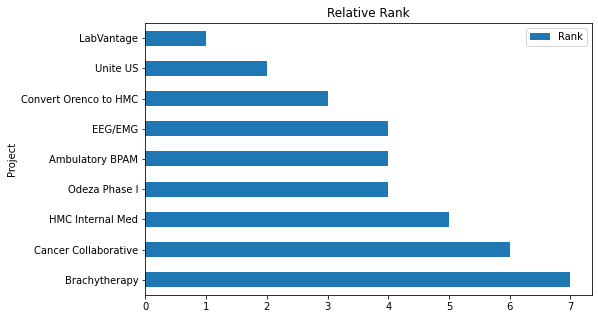

In [10]:
""" SHOW THE RESULTS """
    
dfrank=pd.DataFrame(columns=['Project','Rank'], index=None)


for rank,elem in enumerate(r.ranked_list):
    for item in elem:
        dfrank=dfrank.append({'Project':df_projects[item],'Rank': rank+1}, ignore_index=True)

display(dfrank)        
dfrank=dfrank.sort_values(by=['Rank'],ascending=False)       


dfrank.plot(x='Project',y='Rank',ylabel='Rank',kind='barh', figsize=(8,5), title='Relative Rank')